# Structured memory retrieval

In this notebook, we experiment with a memory retrieval algorithm based on Predictive Coding, using the PC-RNN-HC-A model.
The model is first trained to generate a repertoire of sequence pattern. During memory retrieval, one of the data set sequence is provided as target output and the PC inference mechanisms are used to find the latent variable that best predicts it.

In [1]:
import torch
from torch import nn
import numpy as np

import pickle as pk

from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

## Model

In [2]:
class PC_RNN_HC_A(nn.Module):
    
    def __init__(self, causes_dim, states_dim, output_dim, tau_h, alpha_x, alpha_h):
        super(PC_RNN_HC_A, self).__init__()
        
        self.causes_dim = causes_dim
        self.output_dim = output_dim
        self.states_dim = states_dim
        self.tau_h = tau_h
        self.alpha_x = alpha_x
        self.alpha_h = alpha_h
        
        # Output weights initialization
        self.w_o = torch.randn(self.output_dim, self.states_dim) / self.states_dim
        self.b_o = torch.randn(self.output_dim) / 10
        
        # Recurrent weights initialization
        self.w_c = torch.randn(self.states_dim, self.causes_dim) / self.causes_dim
        self.w_r = torch.randn(self.states_dim, self.states_dim) / self.states_dim
        self.b_r = torch.randn(self.states_dim) / 10
        
        # Predictions, states and errors are temporarily stored for batch learning
        # Learning can be performed online, but computations are slower
        self.x_pred = None
        self.error = None
        self.h_prior = None
        self.h_post = None
        self.c = None
               
    def forward(self, x, c_init, h_init=0, store=True):
        """
        Pass through the network : forward (prediction) and backward (inference) passes are 
         performed at the same time.
        Parameters :        
        - x : target sequences, Tensor of shape (seq_len, batch_size, output_dim)
        - c_init : initial hidden causes (input), Tensor of shape (batch_size, states_dim)
        - h_init : initial hidden state, Tensor of shape (batch_size, states_dim)
        - store : whether to store as attributes the different activations, Boolean
        """

        seq_len, batch_size, _ = x.shape
        
        # Temporary storing of the predictions, states and errors
        if store:
            x_preds = torch.zeros(seq_len, batch_size, self.output_dim)
            h_priors = torch.zeros(seq_len, batch_size, self.states_dim)
            h_posts = torch.zeros(seq_len, batch_size, self.states_dim)
            cs = torch.zeros(seq_len, batch_size, self.causes_dim)
            error_hs = torch.zeros(seq_len, batch_size, self.states_dim)
        errors = torch.zeros(seq_len, batch_size, self.output_dim)
        
        # Initial hidden state and hidden causes
        old_h_post = h_init
        c = c_init
        
        for t in range(seq_len):
            
            # Top-down pass
            
            # Compute h_prior according to past h_post
            h_prior = (1-1/self.tau_h) * old_h_post + (1/self.tau_h) * (
                torch.mm(
                    torch.tanh(old_h_post),
                    self.w_r.T
                ) + \
                torch.mm(
                    c,
                    self.w_c.T
                ) + \
                self.b_r.unsqueeze(0).repeat(batch_size, 1)
            )
            if store:
                h_priors[t] = h_prior.detach()
            
            # Compute x_pred according to h_prior
            x_pred =  torch.mm(torch.tanh(h_prior), self.w_o.T) + self.b_o.unsqueeze(0).repeat(batch_size, 1)
            if store:
                x_preds[t] = x_pred.detach()
            
            # Compute the error on the sensory level
            error = x_pred - x[t]
            errors[t] = error
            
            # Bottom-up pass
            if self.alpha_x > 0:

                # Infer h_post according to h_prior and the error on the sensory level
                h_post = h_prior - self.alpha_x*(1-torch.tanh(h_prior)**2)*torch.mm(error, self.w_o)
                if store:
                    h_posts[t] = h_post.detach()

                # Compute the error on the hidden state level
                error_h = h_prior - h_post
                if store:
                    error_hs[t] = error_h.detach()

                # Infer c according to its past value and the error on the hidden state level
                c = c - self.alpha_h * torch.mm(error_h, self.w_c)
                
                # Apply some noise to c, weighted by the norm of the error on the hidden layer
                c = c + torch.randn_like(c) * torch.sqrt(torch.sum(error_h**2, axis=1)).unsqueeze(1).repeat(1, self.causes_dim) * self.sigma_r
          
                old_h_post = h_post
            
            else:
                old_h_post = h_prior
                
            # Infer c according to its past value and the prior probability on hidden causes
            if self.alpha_c > 0:
                c = c + self.alpha_c * self.complexity(c.detach())
                
            if store:
                cs[t] = c
                
        if store:
            self.error = errors.detach()
            self.x_pred = x_preds
            self.error_h = error_hs
            self.h_prior = h_priors
            self.h_post = h_posts
            self.c = cs
                             
        return errors
        
    def complexity(self, c):
        """
        Computes the gradient of the complexity term of the free energy principle with regard to the prior on c
        Parameters:
        - c : Hidden causes : Tensor of shape (batch_size, causes_dim)
        """
        
        batch_size, causes_dim = c.shape
        p = self.mus.shape[0]
        sigma_c = self.sigma_c
    
        mus = self.mus.unsqueeze(0).repeat(batch_size, 1, 1).reshape(batch_size*p, 1, causes_dim).transpose(1, 2)
        # Tensor of shape (batch_size*p, causes_dim, 1)
        
        c = c.unsqueeze(1).repeat(1, p, 1).reshape(batch_size*p, 1, causes_dim).transpose(1, 2)
        # Tensor of shape (batch_size*p, causes_dim, 1)
        
        exp = 1e-40 + torch.exp(-torch.bmm((c-mus).transpose(1, 2), c-mus)/(2*sigma_c**2))
        # Tensor of shape(batch_size*p, 1, 1)
        
        num = torch.sum(
            ((c - mus) * exp.repeat(1, causes_dim, 1)) \
                .reshape(batch_size*p, causes_dim).reshape(batch_size, p, causes_dim),
            axis=1
        )
        # Tensor of shape(batch_size, causes_dim)
        
        den = torch.sum(exp.reshape(batch_size, p), axis=1) * (2 * self.sigma_c**2)
        # Tensor of shape (batch_size)
        
        return -num/den.unsqueeze(-1).repeat(1, causes_dim)

## Data set

In this experiment we use a data set of 20 2D trajectories corresponding to handwritten letters.

In [3]:
trajs = pk.load(open('handwriting_trajs_20.pk', 'rb'))
trajs = trajs.transpose(1, 0, 2)
print(trajs.shape)

(60, 20, 2)


## Model training

In [4]:
p = 20
causes_dim = 2
states_dim = 50
output_dim = 2
tau = 50
rnn = PC_RNN_HC_A(causes_dim, states_dim, output_dim, tau, alpha_x=0.0, alpha_h=0.0)

# The model is trained using BPTT

# The initial RNN hidden state is shared for all trajectories, and optimized along the model parameters
h_init = torch.nn.Parameter(torch.randn(1, rnn.states_dim).repeat(p, 1))

# The initial hidden causes depend on the trajectory id, and are optimized along the model parameters
c_init = torch.nn.Parameter(torch.randn(p, rnn.causes_dim)*0.01)

# Model parameters
rnn.w_o = torch.nn.Parameter(rnn.w_o)
rnn.b_o = torch.nn.Parameter(rnn.b_o)
rnn.w_c = torch.nn.Parameter(rnn.w_c)
rnn.w_r = torch.nn.Parameter(rnn.w_r)
rnn.b_r = torch.nn.Parameter(rnn.b_r)

# Adam optimizer with weight decay
opt=torch.optim.Adam((c_init, rnn.w_o, rnn.w_c, rnn.w_r, rnn.b_o, rnn.b_r), lr=0.03, weight_decay=1e-4)

# Since there is no bottom-up inference during training, alpha_c has no effect on the computations
# we set it to 0 to speed up training by avoiding unecessary computations
rnn.alpha_c = 0.
rnn.sigma_r = 0.0

iterations = 1000
losses = torch.zeros(iterations)

# Training
for i in tqdm(range(iterations)):
    opt.zero_grad()
    error = rnn.forward(torch.Tensor(trajs[:, :p]), c_init=c_init, h_init=h_init, store=True)
    loss = torch.mean(error**2)
    losses[i] = loss.detach().item()
    loss.backward()
    opt.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

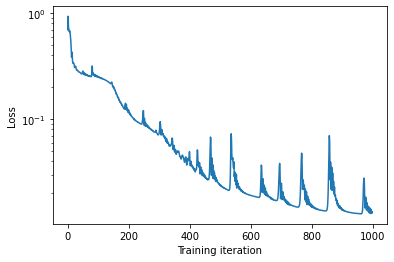

In [5]:
plt.plot(losses)
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

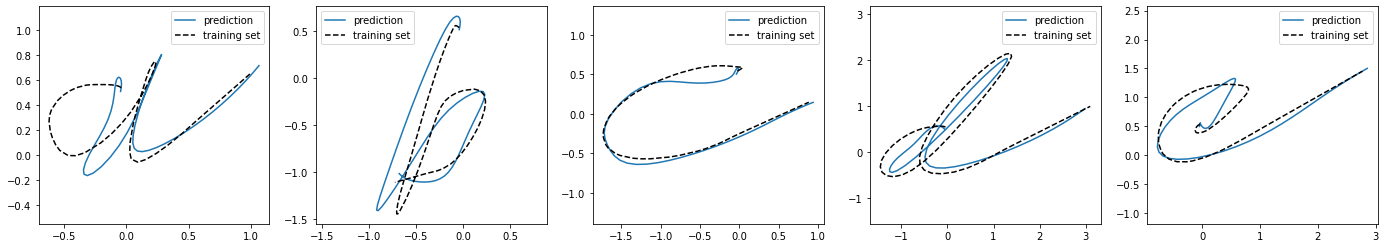

In [6]:
# Example of generated trajectories after learning
rnn.forward(torch.Tensor(trajs[:, :p]), c_init=c_init, h_init=h_init, store=True)

fig = plt.figure(figsize=(24, 4))
axes = fig.subplots(1, 5)
for k in range(5):
    axes[k].plot(rnn.x_pred[:, k, 0], rnn.x_pred[:, k, 1], label='prediction')
    axes[k].plot(trajs[:, k, 0], trajs[:, k, 1], '--', c='black', label='training set')
    axes[k].legend()
    axes[k].axis('equal')
plt.show()

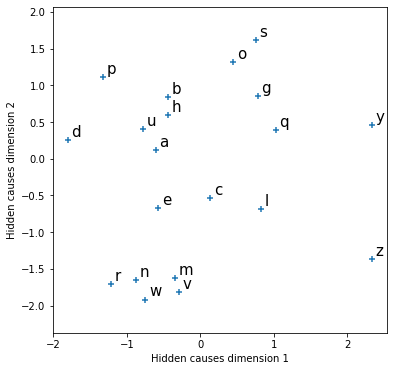

In [11]:
# We can display in 2D the learned hidden causes
labels=['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']

plt.figure(figsize=(6, 6))
plt.scatter(c_init[:, 0].detach(), c_init[:, 1].detach(), marker='+')
for k in range(20):
    plt.text(c_init[k, 0]+0.05, c_init[k, 1]+0.05, labels[k], size=15)

plt.xlabel('Hidden causes dimension 1')
plt.ylabel('Hidden causes dimension 2')
plt.axis('equal')
plt.show()

The hidden causes can be seen as learned representations of the trajectories. We can notice that similar looking trajectories, such as b and h, or r and n, have similar hidden causes representations.

## Memory retrieval

Based on this learned model, we want to verify if the inference mechanisms allow to retrieve the category of a provided target pattern, without prior knowledge of which category it is. The hidden causes are initialized randomly, and a target is provided on the output layer. Compared to the prediction (or generation) mode used so far, this time information propagated from the bottom layer (output) towards the top layer (hidden causes). 

We use hyperparameters that were found using an hyperparameter optimizer:

In [8]:
optimal_sigma_c = 0.096
optimal_alpha_h = 0.019
optimal_alpha_c = 0.0085
optimal_sigma_r = 2.6

In [9]:
# Number of trials, one trial corresponds to one complete forward pass through the network
trials=1000

# Update rates
alpha_x = 0.1
rnn.alpha_x = alpha_x
rnn.alpha_h = optimal_alpha_h
rnn.alpha_c = optimal_alpha_c

# Coefficient weighting the additive noise on hidden causes
rnn.sigma_r = optimal_sigma_r

# Parameters of the Gaussian mixture prior on hidden causes
rnn.sigma_c = optimal_sigma_c
rnn.mus = c_init.detach()

# We perform 4 memory retrievals in parallel, starting from 4 initial random hidden causes
h = h_init.repeat(4, 1)
c = torch.randn(p*4, rnn.causes_dim) * 1

cs = torch.zeros(trials, p*4, rnn.causes_dim)
errors = torch.zeros(trials, p*4)

for i in tqdm(range(trials)):

    rnn.forward(torch.Tensor(trajs).repeat(1, 4, 1), c_init=c, h_init=h, store=True)
    c = rnn.c[-1].detach()
    cs[i] = c

    # Measure the error without any bottom-up inference
    rnn.alpha_x = 0
    error = rnn.forward(torch.Tensor(trajs).repeat(1, 4, 1), c_init=c, h_init=h, store=True)
    errors[i] = torch.mean(torch.sqrt(torch.sum(error.detach()**2, axis=2)), axis=0)
    rnn.alpha_x = alpha_x 

  0%|          | 0/1000 [00:00<?, ?it/s]

We display the obtained trajectories in the hidden causes space (2D). Four different memory retrieval were performed using the target pattern corresponding to a "p". Each blue point correspond to the hidden causes at the end of a complete trial. We can see that in a few trials, the hidden causes converge to the correct representation.

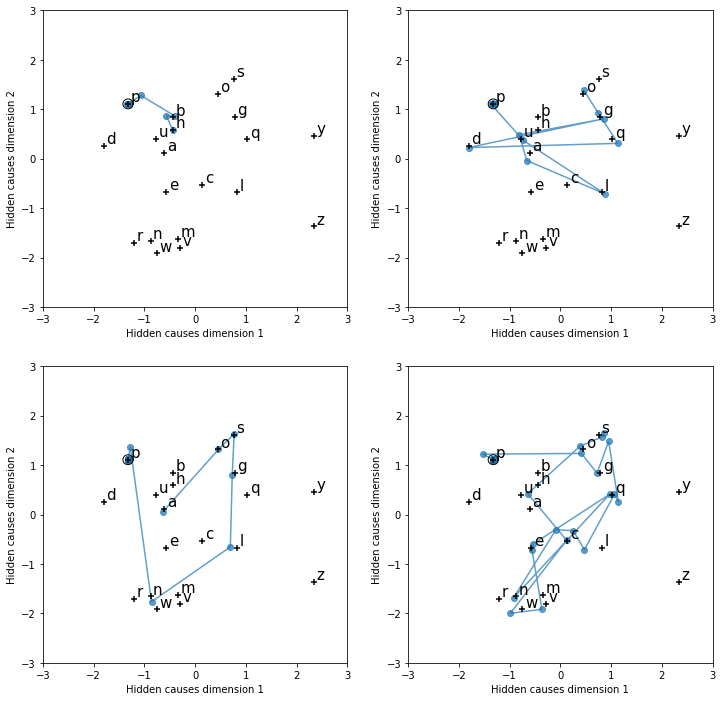

In [10]:
fig = plt.figure(figsize=(12, 12))
axes = fig.subplots(2, 2)

target = 11

cs = cs.reshape(trials, 4, p, rnn.causes_dim)

for t in range(4):
    axes[t//2, t%2].plot(cs[:, t, target, 0], cs[:, t, target, 1], alpha=0.7)
    axes[t//2, t%2].scatter(cs[:, t, target, 0], cs[:, t, target, 1], alpha=0.7)

    axes[t//2, t%2].scatter(c_init[:, 0].detach(), c_init[:, 1].detach(), marker='+', c='black', zorder=5)

    for k in range(20):
        axes[t//2, t%2].text(c_init[k, 0]+0.05, c_init[k, 1]+0.05, labels[k], size=15)

    circle = plt.Circle((c_init[target:target+1, 0], c_init[target:target+1, 1]), 0.1, color='black', fill=False, zorder=5)
    axes[t//2, t%2].add_patch(circle)
    
    axes[t//2, t%2].set_xlim(-3, 3)
    axes[t//2, t%2].set_ylim(-3, 3)
    axes[t//2, t%2].set_xlabel('Hidden causes dimension 1')
    axes[t//2, t%2].set_ylabel('Hidden causes dimension 2')

plt.show()